Step 7: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product considering context generation

In [1]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates
#three user classes

In [99]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Environment.Product import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.CG_Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.CG_UCB_Learner import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],
             np.multiply([0.3, 0.3, 0.3, 0.3],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce()
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

Abbiamo implementato CG LEARNER ENVIRONMENT, PER I LEARNERS usiamo una lista di learners.
RESTA DA IMPLEMENTARE:
1. CAPIRE COME SCRIVERE L'ULTIMA PARTE DEI conversion_rates
2. CONFRONT TS E UCB


## TS AND UCB

In [34]:
#Context generation for TS and random (reset every 2 weeks)

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learner = Conv_rates(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]

    split1_cr = 0
    split2_cr = 0

    split1_ts = 0
    split2_ts = 0

    for period in range(int(n_days/14)):
        print("period",period)
        for d in range(14):
            if split1_cr==0 and split2_cr==0:
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learner.pull_arm()

                reward_cr = env.round(pulled_arm_cr)  #reward_cr[f1][f2][i]
                cr_learner.update(pulled_arm_cr[0][0] , reward_cr[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

            # FIRST DECISION
            if split1_cr==1 and split2_cr==0:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    cr_learners[f1].update(pulled_arm_cr[f1][0], (reward_cr[f1][0]+reward_cr[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_cr==1 and split2_cr==1:  # we add the second split
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_cr == 0 and split2_cr ==1:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f2 in range(2):
                    cr_learners[f2].update(pulled_arm_cr[0][f2], (reward_cr[0][f2]+reward_cr[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))

        # --------------------------------------------------
        # -------------------THOMSON SAMPLING ---------------
        # --------------------------------------------------
        #ciao

            if split1_ts==0 and split2_ts==0:
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                    ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                # FIRST DECISION
            if split1_ts==1 and split2_ts==0:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]+reward_ts[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_ts==1 and split2_ts==1:  # we add the second split
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    for f2 in range(2):
                        ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_ts == 0 and split2_ts ==1:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f2 in range(2):
                    ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))




        # DECISION
        #compute sample probabilities and make decision
        if split1_cr==0 and split2_cr==0:
            mu_c0_cr[split1_cr][split2_cr] = np.sum(np.sum(cr_learner.rewards_per_arm))
            print('mu_c0_cr=',mu_c0_cr)
             # split 1
            collected_reward_crs=np.concatenate((collected_reward_crs, cr_learner.collected_rewards)) #axis=None
            #cr_learners = [cr_learner,cr_learner]
            cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            split1_cr = 1
            split2_cr = 0

        elif split1_cr==1 and split2_cr==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            split2_cr = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]
                split1_cr = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split1_cr = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_cr==1 and split2_cr==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0][0].rewards_per_arm))+np.sum(np.sum(cr_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[0][1].rewards_per_arm))+np.sum(np.sum(cr_learners[1][1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0][0].collected_rewards +
                                              cr_learners[0][1].collected_rewards +
                                              cr_learners[1][0].collected_rewards +
                                              cr_learners[1][1].collected_rewards )
                                              ) #axis=None

            print('mu_c0_cr=',mu_c0_cr)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[1][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_cr == 0 and split2_cr ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                cr_learners = [Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

        
            # DECISION
        #compute sample probabilities and make decision
        if split1_ts==0 and split2_ts==0:
            mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
            print('mu_c0_ts=',mu_c0_ts)
             # split 1
            collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
            #ts_learners = [ts_learner,ts_learner]
            ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
            split1_ts = 1
            split2_ts = 0

        elif split1_ts==1 and split2_ts==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            split2_ts = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                ts_learners = [[TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)] for _ in range(2)]
                split1_ts = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split1_ts = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0][0].collected_rewards +
                                              ts_learners[0][1].collected_rewards +
                                              ts_learners[1][0].collected_rewards +
                                              ts_learners[1][1].collected_rewards )
                                              ) #axis=None


            print('mu_c0_ts=',mu_c0_ts)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[1][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                ts_learners = [TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")




period 0


AttributeError: 'HomogeneousUsers' object has no attribute 'f1'

Stimo clayroviant solution with a simple environment

In [85]:
# FIX THE PRODUCTS PRICES
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],
             np.multiply([0.3, 0.3, 0.3, 0.3],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
print("Margin matrix: ")
print(margins_matrix)

Margin matrix: 
[[ 3.998  5.998  7.998 10.998]
 [ 5.998  8.598 11.998 15.998]
 [ 7.797 10.797 13.797 16.797]
 [15.596 20.596 23.596 26.596]
 [23.997 33.997 43.997 53.997]]


In [86]:
opt = [[0 for _ in range(2)] for _ in range(2)]

In [88]:
# ONLY CLASS 0
E = E_commerce(binary_features=10)
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
E.set_products(products)
E.set_lambda(0.5)

n_arms = 4
num_users = 1000 #mean number of users for each day
n_days = 300
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 100

opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_experiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given choosing each round the best combination
opt[0][0] = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_experiment, axis = 0)[i])#expected_units_sold_per_product[i])#

print("_______________________________________________")
print("----------    FOR THE CLASS 0    ----------")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Rewards per arm of this simple algorithm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate")
print(margins_matrix*np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_experiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt[0][0]) # optimal configuration: the best combination of arms


_______________________________________________
----------    FOR THE CLASS 0    ----------
Conversion rates
[[0.96775592 0.73953457 0.25777643 0.01382279]
 [0.9859998  0.88057043 0.30245131 0.01475401]
 [0.98519256 0.87757682 0.28436836 0.02138952]
 [0.98952205 0.78470414 0.34100228 0.06003201]
 [0.98647972 0.98692025 0.83135535 0.07826398]]
_______________________________________________
Rewards per arm of this simple algorithm
[[ 7.82177037  8.89592459  4.03900699  0.07947769]
 [ 5.96341875  7.63194351  3.59814502  0.10198445]
 [23.33727529 28.77321542 11.60545476  0.46787041]
 [46.66453197 48.80193296 24.01156283  4.31333185]
 [23.997      33.99227819 36.96379994  3.61274176]]
Expected rewards per arm = margin * conversion rate
[[ 3.86908817  4.43572834  2.06169592  0.15202302]
 [ 5.91402677  7.57114454  3.62881078  0.23603469]
 [ 7.68154641  9.47519694  3.92343032  0.35927973]
 [15.43258588 16.16176646  8.0462897   1.59661123]
 [23.67255386 33.55232782 36.57714114  4.22602033]]
__

In [92]:
# ONLY CLASS 1
E = E_commerce(binary_features=20)
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
E.set_products(products)
E.set_lambda(0.5)

n_arms = 4
num_users = 1000 #mean number of users for each day
n_days = 300
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 100

opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_experiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given choosing each round the best combination
opt[1][0] = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_experiment, axis = 0)[i])#expected_units_sold_per_product[i])#

print("_______________________________________________")
print("----------    FOR THE CLASS 1    ----------")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Rewards per arm of this simple algorithm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate")
print(margins_matrix*np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_experiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt[1][0]) # optimal configuration: the best combination of arms

_______________________________________________
----------    FOR THE CLASS 1    ----------
Conversion rates
[[0.90472521 0.49953163 0.10344486 0.01114676]
 [0.95564494 0.66861997 0.116549   0.01052625]
 [0.9519087  0.50069122 0.05306503 0.0125506 ]
 [0.96846229 0.49410579 0.12476898 0.01753383]
 [0.98639807 0.87898565 0.11705097 0.01302585]]
_______________________________________________
Rewards per arm of this simple algorithm
[[ 7.310359    6.00124806  1.5362319   0.00434718]
 [ 5.79081996  5.76531772  1.31242567  0.0116281 ]
 [22.53213546 16.2173925   1.71217268  0.        ]
 [45.70349937 30.53076275  8.05666519  0.67984734]
 [23.98924087 30.22818135  4.69716246  0.        ]]
Expected rewards per arm = margin * conversion rate
[[ 3.61709141  2.99619071  0.82735199  0.12259205]
 [ 5.73195836  5.74879451  1.39835487  0.1683989 ]
 [ 7.4220321   5.40596305  0.73213816  0.21081242]
 [15.10413792 10.17660295  2.94404884  0.46632965]
 [23.67059449 29.88287507  5.14989131  0.70335656]]
__

In [101]:
#class 2
print("Margin matrix: ")
print(margins_matrix)

# ONLY CLASS 2
E = E_commerce(binary_features=30)
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
E.set_products(products)
E.set_lambda(0.5)

n_arms = 4
num_users = 1000 #mean number of users for each day
n_days = 300
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 100

opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_experiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given choosing each round the best combination
opt[1][1] = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_experiment, axis = 0)[i])#expected_units_sold_per_product[i])#

print("_______________________________________________")
print("----------    FOR THE CLASS 2    ----------")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Rewards per arm of this simple algorithm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate")
print(margins_matrix*np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_experiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt[1][1])  # optimal configuration: the best combination of arms

Margin matrix: 
[[ 3.998  5.998  7.998 10.998]
 [ 5.998  8.598 11.998 15.998]
 [ 7.797 10.797 13.797 16.797]
 [15.596 20.596 23.596 26.596]
 [23.997 33.997 43.997 53.997]]
_______________________________________________
----------    FOR THE CLASS 2    ----------
Conversion rates
[[0.74978564 0.25853372 0.03398258 0.01153039]
 [0.95117376 0.67371047 0.11795811 0.01118014]
 [0.87469185 0.2945738  0.02015486 0.01243752]
 [0.880423   0.21560355 0.03242602 0.00990727]
 [0.97641278 0.1744738  0.01332569 0.01305866]]
_______________________________________________
Rewards per arm of this simple algorithm
[[ 6.05315194  3.02867606  0.36193174  0.00118258]
 [ 5.75758306  5.83779434  1.32233     0.00437093]
 [20.699963    9.34051004  0.30225928  0.        ]
 [41.58623991 13.03736289  1.63097107  0.03738668]
 [23.73480685  5.63341631  0.          0.        ]]
Expected rewards per arm = margin * conversion rate
[[ 2.99764301  1.55068527  0.27179266  0.12681125]
 [ 5.7051402   5.79256262  1.415261

In [91]:
#completo
opt

[[130.19988411266178, 0], [110.7383026896452, 95.9049040104222]]

## Per stimare clayroviant solution

In [68]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],
             np.multiply([0.3, 0.3, 0.3, 0.3],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce(binary_features=1)
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [69]:
#SPlit finale
#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 5
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)], [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]]

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    for d in range(300):
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])
                        collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[f1][f2].collected_rewards))

    conversion_rates = [[np.zeros((5,4)) for _ in range(2)] for _ in range(2)]
    np.set_printoptions(suppress=True)

    


    for f1 in range(2):
            for f2 in range(2):
                for i in range(5):
                    conversion_rates[f1][f2][i] = cr_learners[f1][f2].beta_parameters[i][:,0]/(cr_learners[f1][f2].beta_parameters[i][:,0]+cr_learners[f1][f2].beta_parameters[i][:,1])
                    opt_vector[f1][f2][e] += np.max(np.array(E.products[f1][f2][i].margins_list) * conversion_rates[f1][f2][i] * cr_learners[f1][f2].lambda_poisson[i])
                conv_rates_per_experiment[f1][f2].append(conversion_rates[f1][f2])

                mean_units_sold_per_product_per_eperiment[f1][f2].append(cr_learners[f1][f2].lambda_poisson)
                cr_learner_expected_rewards_per_experiment[f1][f2].append(cr_learners[f1][f2].expected_rewards)


opt = [[0 for _ in range(2)] for _ in range(2)]
opt2 = [[0 for _ in range(2)] for _ in range(2)]
for f1 in range(2):
    for f2 in range(2):
        opt[f1][f2] = np.mean(opt_vector[f1][f2]) #+ np.std(opt_vector)
        opt2[f1][f2] = np.min(opt_vector[f1][f2])


best_arm_per_product = [[np.zeros(5) for i in range(2)] for i in range(2)]
for f1 in range(2):
    for f2 in range(2):

        for i in range(5):   
            best_arm_per_product[f1][f2][i] = np.argmax(np.array(E.products[f1][f2][i].margins_list) * np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i] 
                                                * np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)[i])#expected_units_sold_per_product[i])#


In [70]:
for f1 in range(2):
    for f2 in range(2):
        print(best_arm_per_product[f1][f2])

[3. 3. 3. 3. 3.]
[0. 0. 0. 0. 0.]
[3. 3. 3. 3. 3.]
[0. 0. 0. 0. 0.]


In [71]:
for f1 in range(2):
    for f2 in range(2):
        print("features",f1,f2)
        for i in range(5):
            print(np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i])

features 0 0
[0.53504986 0.50029808 0.51520398 0.48534125]
[0.47385021 0.47102261 0.46627045 0.51110252]
[0.47975212 0.55071628 0.45833803 0.56768482]
[0.53071001 0.52477235 0.5677977  0.51487049]
[0.74670894 0.75012591 0.71719884 0.6968677 ]
features 0 1
[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
features 1 0
[0.26864982 0.25167095 0.2961659  0.2363583 ]
[0.31961507 0.28495254 0.31196955 0.32745436]
[0.38185813 0.41232417 0.35197607 0.38697975]
[0.36144161 0.39314527 0.39545699 0.3865489 ]
[0.48478639 0.45436097 0.5439987  0.57562011]
features 1 1
[0.74302368 0.27174953 0.02640515 0.00205961]
[0.69637855 0.20691413 0.01161157 0.001934  ]
[0.86745966 0.29172532 0.01507265 0.00207018]
[0.89282488 0.22983654 0.02451118 0.00248585]
[0.98642661 0.17698991 0.00228421 0.00249071]


In [72]:
opt, opt2

([[127.81944493889178, 0.0], [94.15347132668735, 97.07456530524532]],
 [[121.30842735353889, 0.0], [84.7267910788645, 95.50883354657556]])

## THOMPSON REWARD TOTALE (no reset)

In [57]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],
             np.multiply([0.3, 0.3, 0.3, 0.3],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce(binary_features=1)
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [58]:
#THOMPSON REWARD TOTALE (no reset)

np.random.seed(1000)
n_arms = 4
num_users = 1000
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    ts_learner = TS_poisson(n_arms=n_arms)


    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    split1_ts = 0
    split2_ts = 0

    for d in range(int(n_days*3/14)):
        for d in range(14):

                
            # --------------------------------------------------
            # -------------------THOMSON SAMPLING ---------------
            # --------------------------------------------------
            #ciao

                if split1_ts==0 and split2_ts==0:
                        for f1 in range(2):
                            for f2 in range(2):
                                pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                        reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                        ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                    # FIRST DECISION
                if split1_ts==1 and split2_ts==0:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)
                    P = env.E.users_by_class/np.sum(env.E.users_by_class)
                    p_c1 = P[0][0] + P[0][1]
                    p_c2 = P[1][0] + P[1][1]
                    for f1 in range(2):
                        ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]*p_c1+reward_ts[f1][1]*p_c2), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

                elif split1_ts==1 and split2_ts==1:  # we add the second split
 
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])


                elif split1_ts == 0 and split2_ts ==1:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f2 in range(2):
                        ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))


            # DECISION
        if split1_ts==0 and split2_ts==0:
                mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
                #print('mu_c0_ts=',mu_c0_ts)
                # split 1
                collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
                #ts_learners = [ts_learner,ts_learner]
                ts_learner1 = copy.deepcopy(ts_learner)
                ts_learner2 = copy.deepcopy(ts_learner)
                ts_learner1.reset()
                ts_learner2.reset()
                ts_learners = [ts_learner1,ts_learner2]
                split1_ts = 1
                split2_ts = 0

        elif (split1_ts==1 and split2_ts==0):
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[0][1]
                p_c2 = P[1][0] + P[1][1]
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                # we consider the second split
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                split2_ts = 1  # in ogni caso consideremo la seconds feature
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards*p_c1 + ts_learners[1].collected_rewards*p_c2)) #axis=None
                
                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:

                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner3 = copy.deepcopy(ts_learner)
                    ts_learner4 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learner3.reset()
                    ts_learner4.reset()
                    ts_learners = [[ts_learner1,ts_learner2],[ts_learner3,ts_learner4]]
                    split1_ts = 1
                    #print("--- SPLIT F1 MAKES SENSE ---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1,ts_learner2]
                    split1_ts = 0
                    #print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:

                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0][0].collected_rewards*P[0][0] +
                                                ts_learners[0][1].collected_rewards*P[0][1] +
                                                ts_learners[1][0].collected_rewards*P[1][0] +
                                                ts_learners[1][1].collected_rewards*P[1][1] )
                                                ) #axis=None
                #print('mu_c0_ts=',mu_c0_ts)
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

                if p_c1*mu_c1 + p_c2*mu_c2 >mu_c0_ts[1][0]:
                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (together with f1)---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learners[0][0])
                    ts_learner2 = copy.deepcopy(ts_learner[1][0])
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1 ,ts_learner2]
                    split2_ts = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

                # we consider the second split
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards*p_c1 + ts_learners[1].collected_rewards*p_c2)) #axis=None

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                    ts_learner1.reset()
                    ts_learner2.reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (without f1)---")
                    #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                else:
                    ts_learners = [TS_poisson(n_arms=n_arms)]
                    split2_ts = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

    

In [59]:
OPT = opt[0][0] * 0.3 + opt[1][0]*0.4 + 0.3*opt[1][1]

In [60]:
OPT, np.mean(collected_reward_tss)

(110.62610752228602, 148.65416685442054)

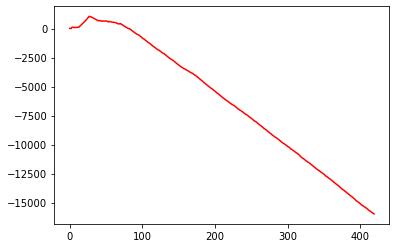

In [61]:
plt.plot(np.cumsum(OPT - collected_reward_tss, axis=0), 'r')

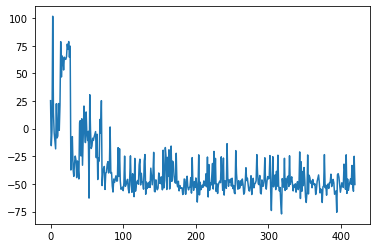

In [62]:
plt.plot(OPT - collected_reward_tss)

In [63]:
#UCB REWARD TOTALE (no reset)

np.random.seed(1000)
n_arms = 4
num_users = 1000
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_ucbs = np.array([])

mu_c0_ucb = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    ucb_learner = UCB(n_arms=n_arms)


    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    split1_ucb = 0
    split2_ucb = 0

    for d in range(int(n_days*3/14)):
        for d in range(14):

                
            # --------------------------------------------------
            # -------------------THOMSON SAMPLING ---------------
            # --------------------------------------------------
            #ciao

                if split1_ucb==0 and split2_ucb==0:
                        for f1 in range(2):
                            for f2 in range(2):
                                pulled_arm_ucb[f1][f2] = ucb_learner.pull_arm( )

                        reward_ucb = env.round(pulled_arm_ucb)  #reward_ucb[f1][f2][i]
                        ucb_learner.update(pulled_arm_ucb[0][0] , reward_ucb[0][0])

                    # FIRST DECISION
                if split1_ucb==1 and split2_ucb==0:
                    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ucb[f1][f2] = ucb_learners[f1].pull_arm( )

                    reward_ucb = env.round(pulled_arm_ucb)
                    P = env.E.users_by_class/np.sum(env.E.users_by_class)
                    p_c1 = P[0][0] + P[0][1]
                    p_c2 = P[1][0] + P[1][1]
                    for f1 in range(2):
                        ucb_learners[f1].update(pulled_arm_ucb[f1][0], (reward_ucb[f1][0]*p_c1+reward_ucb[f1][1]*p_c2))

                elif split1_ucb==1 and split2_ucb==1:  # we add the second split
 
                    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ucb[f1][f2] = ucb_learners[f1][f2].pull_arm( )

                    reward_ucb = env.round(pulled_arm_ucb)

                    for f1 in range(2):
                        for f2 in range(2):
                            ucb_learners[f1][f2].update(pulled_arm_ucb[f1][f2], reward_ucb[f1][f2])


                elif split1_ucb == 0 and split2_ucb ==1:
                    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ucb[f1][f2] = ucb_learners[f2].pull_arm( )

                    reward_ucb = env.round(pulled_arm_ucb)

                    for f2 in range(2):
                        ucb_learners[f2].update(pulled_arm_ucb[0][f2], (reward_ucb[0][f2]+reward_ucb[1][f2]))


            # DECISION
        if split1_ucb==0 and split2_ucb==0:
                mu_c0_ucb[split1_ucb][split2_ucb] = np.sum(np.sum(ucb_learner.rewards_per_arm))
                #print('mu_c0_ucb=',mu_c0_ucb)
                # split 1
                collected_reward_ucbs=np.concatenate((collected_reward_ucbs, ucb_learner.collected_rewards)) #axis=None
                #ucb_learners = [ucb_learner,ucb_learner]
                ucb_learner1 = copy.deepcopy(ucb_learner)
                ucb_learner2 = copy.deepcopy(ucb_learner)
                ucb_learner1.reset()
                ucb_learner2.reset()
                ucb_learners = [ucb_learner1,ucb_learner2]
                split1_ucb = 1
                split2_ucb = 0

        elif (split1_ucb==1 and split2_ucb==0):
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[0][1]
                p_c2 = P[1][0] + P[1][1]
                mu_c1 = np.sum(np.sum(ucb_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ucb_learners[1].rewards_per_arm))

                # we consider the second split
                mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2
                split2_ucb = 1  # in ogni caso consideremo la seconds feature
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ucb=',mu_c0_ucb)
                collected_reward_ucbs=np.concatenate((collected_reward_ucbs,
                                                    ucb_learners[0].collected_rewards*p_c1 + ucb_learners[1].collected_rewards*p_c2)) #axis=None
                
                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ucb[0][0]:

                    ucb_learner1 = copy.deepcopy(ucb_learner)
                    ucb_learner2 = copy.deepcopy(ucb_learner)
                    ucb_learner3 = copy.deepcopy(ucb_learner)
                    ucb_learner4 = copy.deepcopy(ucb_learner)
                    ucb_learner1.reset()
                    ucb_learner2.reset()
                    ucb_learner3.reset()
                    ucb_learner4.reset()
                    ucb_learners = [[ucb_learner1,ucb_learner2],[ucb_learner3,ucb_learner4]]
                    split1_ucb = 1
                    #print("--- SPLIT F1 MAKES SENSE ---")
                else:
                    ucb_learner1 = copy.deepcopy(ucb_learner)
                    ucb_learner2 = copy.deepcopy(ucb_learner)
                    ucb_learner1.reset()
                    ucb_learner2.reset()
                    ucb_learners = [ucb_learner1,ucb_learner2]
                    split1_ucb = 0
                    #print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ucb==1 and split2_ucb==1:

                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ucb_learners[0][0].rewards_per_arm))+np.sum(np.sum(ucb_learners[1][0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ucb_learners[0][1].rewards_per_arm))+np.sum(np.sum(ucb_learners[1][1].rewards_per_arm))

                mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2
                collected_reward_ucbs=np.concatenate((collected_reward_ucbs,
                                                    ucb_learners[0][0].collected_rewards*P[0][0] +
                                                ucb_learners[0][1].collected_rewards*P[0][1] +
                                                ucb_learners[1][0].collected_rewards*P[1][0] +
                                                ucb_learners[1][1].collected_rewards*P[1][1] )
                                                ) #axis=None
                #print('mu_c0_ucb=',mu_c0_ucb)
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

                if p_c1*mu_c1 + p_c2*mu_c2 >mu_c0_ucb[1][0]:
                    for f1 in range(2):
                        for f2 in range(2):
                            ucb_learners[f1][f2].reset()
                    mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (together with f1)---")
                else:
                    ucb_learner1 = copy.deepcopy(ucb_learners[0][0])
                    ucb_learner2 = copy.deepcopy(ucb_learner[1][0])
                    ucb_learner1.reset()
                    ucb_learner2.reset()
                    ucb_learners = [ucb_learner1 ,ucb_learner2]
                    split2_ucb = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ucb == 0 and split2_ucb ==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ucb_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ucb_learners[1].rewards_per_arm))

                mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2

                # we consider the second split
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ucb=',mu_c0_ucb)
                collected_reward_ucbs=np.concatenate((collected_reward_ucbs,
                                                    ucb_learners[0].collected_rewards*p_c1 + ucb_learners[1].collected_rewards*p_c2)) #axis=None

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ucb[0][0]:
                    ucb_learner1.reset()
                    ucb_learner2.reset()
                    mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (without f1)---")
                    #ucb_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                else:
                    ucb_learners = [UCB(n_arms=n_arms)]
                    split2_ucb = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")



/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [64]:
OPT, np.mean(collected_reward_tss), np.mean(collected_reward_ucbs)

(110.62610752228602, 148.65416685442054, 159.9423756675938)

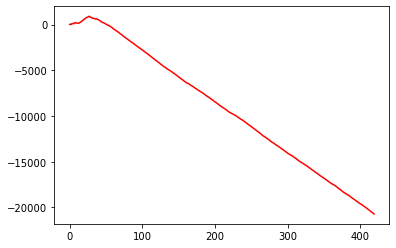

In [65]:
plt.plot(np.cumsum(OPT - collected_reward_ucbs, axis=0), 'r')

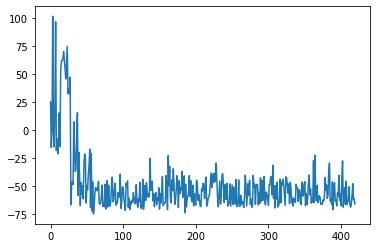

In [66]:
plt.plot(OPT - collected_reward_ucbs)